# BERT-Based Sentiment Analysis for Singapore Airlines Reviews

## Abstract
This notebook implements a transformer-based sentiment classification model using BERT (Bidirectional Encoder Representations from Transformers) to analyze customer reviews of Singapore Airlines. The model classifies sentiments into three categories: positive, neutral, and negative.

## Table of Contents
1. Environment Setup and Dependencies
2. Data Loading and Exploration
3. Data Preprocessing
4. BERT Model Configuration
5. Training Pipeline
6. Model Evaluation
7. Inference and Testing
8. Results Analysis

## 1. Environment Setup and Dependencies

In [ ]:
# Install required packages (run once)
!pip install transformers torch pandas numpy scikit-learn matplotlib seaborn tqdm

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Deep Learning libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Transformers
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup
)

from torch.optim import AdamW

# Scikit-learn
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)
from sklearn.preprocessing import LabelEncoder

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")

PyTorch Version: 2.9.0+cu126
CUDA Available: True
CUDA Device: NVIDIA GeForce RTX 3060 Laptop GPU


In [2]:
# Configuration parameters
class Config:
    """Configuration class containing all hyperparameters"""
    
    # Model parameters
    MODEL_NAME = 'bert-base-uncased'
    MAX_LENGTH = 128  # Maximum sequence length
    NUM_CLASSES = 3   # positive, neutral, negative
    
    # Training parameters
    BATCH_SIZE = 16
    LEARNING_RATE = 2e-5
    NUM_EPOCHS = 3
    WARMUP_STEPS = 0
    WEIGHT_DECAY = 0.01

    MODEL_SAVE_PATH = "./outputs/bert-sia-3class"
    
    # Device configuration
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


config = Config()
print(f"Using device: {config.DEVICE}")

Using device: cuda


## 2. Data Loading and Exploration

In [ ]:
# Load datasets
train_df = pd.read_csv("../data/combined_split/train_split.csv")
val_df = pd.read_csv("../data/combined_split/val_split.csv")
test_df = pd.read_csv("../data/combined_split/test_split.csv")

print("Dataset Sizes:")
print(f"Training set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")
print(f"\nTotal samples: {len(train_df) + len(val_df) + len(test_df)}")

Dataset Sizes:
Training set: 8165 samples
Validation set: 1167 samples
Test set: 2333 samples

Total samples: 11665


In [4]:
# Display sample data
print("Sample Training Data:")
print(train_df.head())
print("\nData Info:")
print(train_df.info())
print("\nLabel Distribution:")
print(train_df['label'].value_counts())

Sample Training Data:
   index                                               text     label
0   1218  Luggage Scam via subdivision airline I had to ...  negative
1   6783  Probably the best Airline around Have been fly...  positive
2   7890  Singapore to Bali, Indonesia We have 4 flights...  positive
3   1363  Singapore to Denpasar on SQ948 Good to be back...  positive
4   9108  Service with a Smile Our journey started in th...  positive

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8165 entries, 0 to 8164
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   8165 non-null   int64 
 1   text    8165 non-null   object
 2   label   8165 non-null   object
dtypes: int64(1), object(2)
memory usage: 191.5+ KB
None

Label Distribution:
label
positive    5923
negative    1467
neutral      775
Name: count, dtype: int64


In [5]:
import pandas as pd

df = train_df.copy()  # columns: ["index","text","label"]

# target size = size of the largest class
max_n = df['label'].value_counts().max()

balanced = (
    df.groupby('label', group_keys=False)
      .apply(lambda g: g.sample(n=max_n, replace=True, random_state=42))
      .sample(frac=1, random_state=42)   # shuffle
      .reset_index(drop=True)
)

print(balanced['label'].value_counts())  # now roughly equal


label
negative    5923
positive    5923
neutral     5923
Name: count, dtype: int64


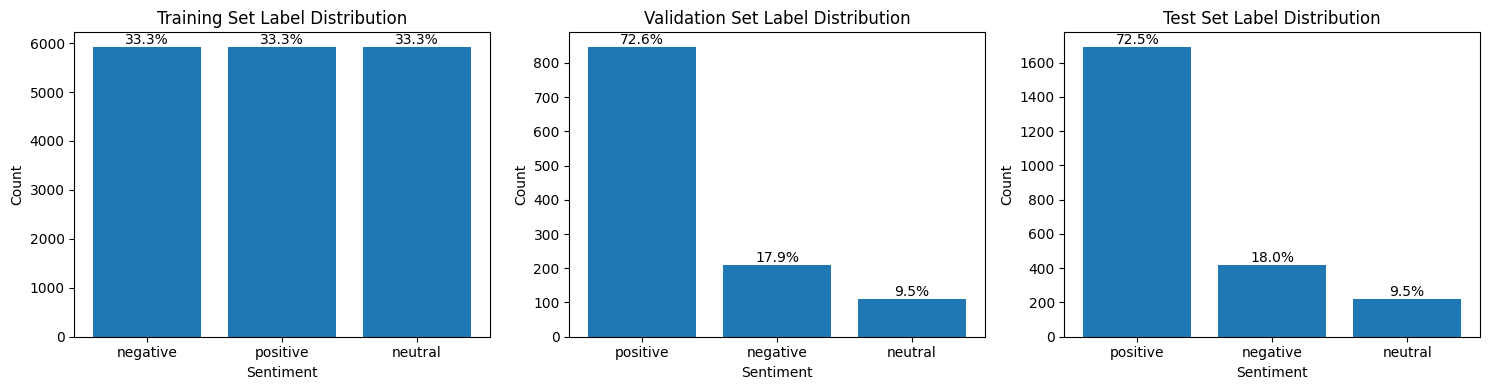

In [6]:
# Visualize label distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

datasets = [('Training', balanced), ('Validation', val_df), ('Test', test_df)]

for idx, (title, df) in enumerate(datasets):
    label_counts = df['label'].value_counts()
    axes[idx].bar(label_counts.index, label_counts.values)
    axes[idx].set_title(f'{title} Set Label Distribution')
    axes[idx].set_xlabel('Sentiment')
    axes[idx].set_ylabel('Count')
    
    # Add percentage labels
    for i, (label, count) in enumerate(label_counts.items()):
        percentage = (count / len(df)) * 100
        axes[idx].text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 3. Data Preprocessing

In [7]:
# Encode labels
label_encoder = LabelEncoder()

# Fit on all possible labels
all_labels = pd.concat([balanced['label'], val_df['label'], test_df['label']]).unique()
label_encoder.fit(all_labels)

# Transform labels
balanced['label_encoded'] = label_encoder.transform(balanced['label'])
val_df['label_encoded'] = label_encoder.transform(val_df['label'])
test_df['label_encoded'] = label_encoder.transform(test_df['label'])

# Display label mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Encoding Mapping:")
for label, encoding in label_mapping.items():
    print(f"  {label}: {encoding}")

Label Encoding Mapping:
  negative: 0
  neutral: 1
  positive: 2


In [8]:
class SentimentDataset(Dataset):
    """Custom Dataset for sentiment analysis"""
    
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Tokenize the text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [9]:
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained(config.MODEL_NAME)
print(f"Tokenizer loaded: {config.MODEL_NAME}")
print(f"Vocabulary size: {tokenizer.vocab_size}")

Tokenizer loaded: bert-base-uncased
Vocabulary size: 30522


In [10]:
# Create datasets
train_dataset = SentimentDataset(
    texts=balanced['text'].values,
    labels=balanced['label_encoded'].values,
    tokenizer=tokenizer,
    max_length=config.MAX_LENGTH
)

val_dataset = SentimentDataset(
    texts=val_df['text'].values,
    labels=val_df['label_encoded'].values,
    tokenizer=tokenizer,
    max_length=config.MAX_LENGTH
)

test_dataset = SentimentDataset(
    texts=test_df['text'].values,
    labels=test_df['label_encoded'].values,
    tokenizer=tokenizer,
    max_length=config.MAX_LENGTH
)

# # Create data loaders
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 1111
Number of validation batches: 73
Number of test batches: 146


In [11]:
# Test data loader
sample_batch = next(iter(train_loader))
print("Sample batch shapes:")
print(f"  Input IDs: {sample_batch['input_ids'].shape}")
print(f"  Attention Mask: {sample_batch['attention_mask'].shape}")
print(f"  Labels: {sample_batch['label'].shape}")
print(f"\nSample text: {sample_batch['text'][0][:100]}...")
print(f"Sample label: {sample_batch['label'][0].item()}")

Sample batch shapes:
  Input IDs: torch.Size([16, 128])
  Attention Mask: torch.Size([16, 128])
  Labels: torch.Size([16])

Sample text: Flights from BNE to Phuket Return The Full Service airline flight to Phuket was great, the staff are...
Sample label: 2


## 4. BERT Model Configuration

In [12]:
# Initialize BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained(
    config.MODEL_NAME,
    num_labels=config.NUM_CLASSES,
    output_attentions=False,
    output_hidden_states=False
)

# Move model to device
model = model.to(config.DEVICE)

# Model summary
print(f"Model loaded: {config.MODEL_NAME}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded: bert-base-uncased
Number of parameters: 109,484,547
Number of trainable parameters: 109,484,547


In [13]:
# Setup optimizer and scheduler
optimizer = AdamW(
    model.parameters(),
    lr=config.LEARNING_RATE,
    weight_decay=config.WEIGHT_DECAY
)

# Total training steps
total_steps = len(train_loader) * config.NUM_EPOCHS

# Learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=config.WARMUP_STEPS,
    num_training_steps=total_steps
)

print(f"Total training steps: {total_steps}")
print(f"Warmup steps: {config.WARMUP_STEPS}")

Total training steps: 3333
Warmup steps: 0


## 5. Training Pipeline

In [14]:
# criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.10)
# # 0.8856 for 0.10
# # 0.9921 for no label smoothing

def train_epoch(model, data_loader, optimizer, scheduler, device):
    """Train the model for one epoch with label smoothing"""
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    progress_bar = tqdm(data_loader, desc='Training')

    for batch in progress_bar:
        input_ids      = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels         = batch['label'].to(device)

        optimizer.zero_grad()

        # 2) 不把 labels 传给 model；取 logits 自己算 loss
        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        logits  = outputs.logits

        loss = outputs.loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

        # metrics
        preds = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(preds == labels).item()
        total_predictions   += labels.size(0)

        total_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy


def evaluate_model(model, data_loader, device):
    """Evaluate the model with the same smoothed criterion"""
    model.eval()
    total_loss = 0.0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating'):
            input_ids      = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels         = batch['label'].to(device)

            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            logits  = outputs.logits

            # 评估也用同一 criterion（只是不会影响指标计算）
            loss = outputs.loss
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(true_labels, predictions)
    return avg_loss, accuracy, predictions, true_labels

In [15]:
# Training loop
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_accuracy = 0

print("Starting training...\n")

for epoch in range(config.NUM_EPOCHS):
    print(f"Epoch {epoch + 1}/{config.NUM_EPOCHS}")
    print("-" * 50)
    
    # Training
    train_loss, train_acc = train_epoch(
        model, train_loader, optimizer, scheduler, config.DEVICE
    )
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")
    
    # Validation
    val_loss, val_acc, _, _ = evaluate_model(
        model, val_loader, config.DEVICE
    )
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
    
    # Save best model
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(model.state_dict(), config.MODEL_SAVE_PATH)
        print(f"Best model saved with validation accuracy: {val_acc:.4f}")
    
    print()

print("Training completed!")
print(f"Best validation accuracy: {best_val_accuracy:.4f}")

Starting training...

Epoch 1/3
--------------------------------------------------


Training: 100%|██████████| 1111/1111 [05:25<00:00,  3.41it/s, loss=0.3653]


Training Loss: 0.3538, Training Accuracy: 0.8676


Evaluating: 100%|██████████| 73/73 [00:07<00:00, 10.36it/s]


Validation Loss: 0.5747, Validation Accuracy: 0.8680
Best model saved with validation accuracy: 0.8680

Epoch 2/3
--------------------------------------------------


Training: 100%|██████████| 1111/1111 [05:32<00:00,  3.34it/s, loss=0.0039]


Training Loss: 0.0803, Training Accuracy: 0.9817


Evaluating: 100%|██████████| 73/73 [00:07<00:00,  9.43it/s]


Validation Loss: 0.6993, Validation Accuracy: 0.8698
Best model saved with validation accuracy: 0.8698

Epoch 3/3
--------------------------------------------------


Training: 100%|██████████| 1111/1111 [05:33<00:00,  3.33it/s, loss=0.0007]


Training Loss: 0.0246, Training Accuracy: 0.9941


Evaluating: 100%|██████████| 73/73 [00:07<00:00,  9.64it/s]


Validation Loss: 0.7900, Validation Accuracy: 0.8766
Best model saved with validation accuracy: 0.8766

Training completed!
Best validation accuracy: 0.8766


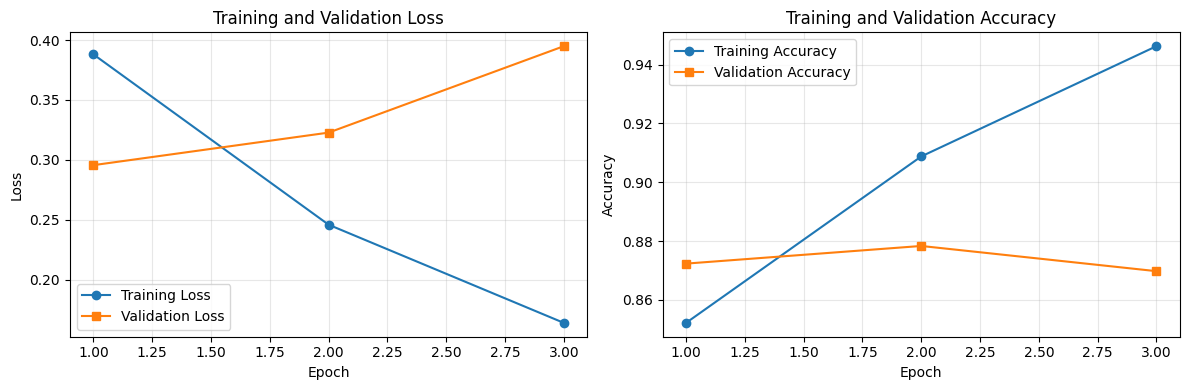

In [16]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
axes[0].plot(range(1, config.NUM_EPOCHS + 1), train_losses, label='Training Loss', marker='o')
axes[0].plot(range(1, config.NUM_EPOCHS + 1), val_losses, label='Validation Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(range(1, config.NUM_EPOCHS + 1), train_accuracies, label='Training Accuracy', marker='o')
axes[1].plot(range(1, config.NUM_EPOCHS + 1), val_accuracies, label='Validation Accuracy', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Model Evaluation

In [16]:
# Load best model
model.load_state_dict(torch.load(config.MODEL_SAVE_PATH))
print("Best model loaded for evaluation")

Best model loaded for evaluation


In [17]:
# Evaluate on test set
test_loss, test_acc, test_predictions, test_labels = evaluate_model(
    model, test_loader, config.DEVICE
)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Evaluating: 100%|██████████| 146/146 [00:13<00:00, 10.86it/s]

Test Loss: 0.7914
Test Accuracy: 0.8800


In [18]:
# Detailed classification report
print("\nClassification Report:")
print("=" * 50)
print(classification_report(
    test_labels, 
    test_predictions, 
    target_names=label_encoder.classes_
))


Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.81      0.81       419
     neutral       0.51      0.47      0.49       222
    positive       0.94      0.96      0.95      1692

    accuracy                           0.89      2333
   macro avg       0.76      0.74      0.75      2333
weighted avg       0.88      0.89      0.88      2333



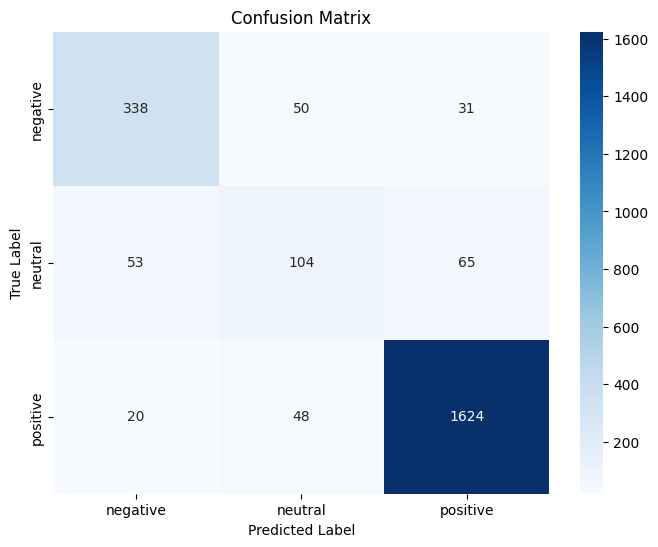


Per-class Accuracy:
  negative: 0.8067
  neutral: 0.4685
  positive: 0.9598


In [19]:
# Confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate per-class accuracy
print("\nPer-class Accuracy:")
for i, label in enumerate(label_encoder.classes_):
    class_acc = cm[i, i] / cm[i].sum()
    print(f"  {label}: {class_acc:.4f}")

## 7. Inference and Testing

In [40]:
def predict_sentiment(text, model, tokenizer, device, max_length=128):
    """Predict sentiment for a single text sample"""
    
    model.eval()
    
    # Tokenize
    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )
    
    # Move to device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Predict
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.nn.functional.softmax(logits, dim=-1)
        
        # Get prediction
        _, prediction = torch.max(logits, dim=-1)
        predicted_class = label_encoder.inverse_transform([prediction.cpu().numpy()[0]])[0]
        
        # Get confidence scores
        confidence_scores = probabilities.cpu().numpy()[0]
    
    return {
        'prediction': predicted_class,
        'confidence_scores': {
            label: float(confidence_scores[i]) 
            for i, label in enumerate(label_encoder.classes_)
        }
    }

In [44]:
# Test with sample reviews
sample_reviews = [
    "The flight was absolutely fantastic! Great service and comfortable seats.",
    "Terrible experience. The staff was rude and the flight was delayed for hours.",
    "The flight was okay, nothing special but got me to my destination.",
    "Singapore Airlines provides exceptional service with attention to detail.",
    "Very disappointed with the meal quality and entertainment system."
]

print("Sample Predictions:")
print("=" * 80)

for review in sample_reviews:
    result = predict_sentiment(review, model, tokenizer, config.DEVICE)
    
    print(f"\nReview: {review[:100]}..." if len(review) > 100 else f"\nReview: {review}")
    print(f"Prediction: {result['prediction'].upper()}")
    print("Confidence Scores:")
    for label, score in result['confidence_scores'].items():
        print(f"  {label}: {score:.4f}")
    print("-" * 40)

Sample Predictions:

Review: The flight was absolutely fantastic! Great service and comfortable seats.
Prediction: POSITIVE
Confidence Scores:
  negative: 0.0027
  neutral: 0.0070
  positive: 0.9903
----------------------------------------

Review: Terrible experience. The staff was rude and the flight was delayed for hours.
Prediction: NEGATIVE
Confidence Scores:
  negative: 0.9166
  neutral: 0.0697
  positive: 0.0137
----------------------------------------

Review: The flight was okay, nothing special but got me to my destination.
Prediction: POSITIVE
Confidence Scores:
  negative: 0.0048
  neutral: 0.0479
  positive: 0.9473
----------------------------------------

Review: Singapore Airlines provides exceptional service with attention to detail.
Prediction: POSITIVE
Confidence Scores:
  negative: 0.0031
  neutral: 0.0070
  positive: 0.9899
----------------------------------------

Review: Very disappointed with the meal quality and entertainment system.
Prediction: NEUTRAL
Confiden

In [45]:
# Error analysis - Find misclassified examples
misclassified_indices = np.where(np.array(test_labels) != np.array(test_predictions))[0]
print(f"Number of misclassified samples: {len(misclassified_indices)}")
print(f"Error rate: {len(misclassified_indices) / len(test_labels):.2%}")

if len(misclassified_indices) > 0:
    print("\nSample Misclassified Reviews:")
    print("=" * 80)
    
    # Show first 5 misclassified examples
    for i in misclassified_indices[:5]:
        actual_label = label_encoder.inverse_transform([test_labels[i]])[0]
        predicted_label = label_encoder.inverse_transform([test_predictions[i]])[0]
        text_sample = test_df.iloc[i]['text'][:200]
        
        print(f"\nText: {text_sample}...")
        print(f"Actual: {actual_label}, Predicted: {predicted_label}")
        print("-" * 40)

Number of misclassified samples: 229
Error rate: 11.45%

Sample Misclassified Reviews:

Text: Disappointing  After leaving our cruise ship in Tokyo, we flew to Melbourne via Singapore on Singapore Airlines. I had flown with this airline many years ago and thought that it was good, so I was dis...
Actual: negative, Predicted: neutral
----------------------------------------

Text: West Jet direct flight available from Calgary to San Diego. it only takes 3 hours and 11 minutes or so. They charged for check in luggage. $30 each bag USD & CAD each way. they provide a drink and sna...
Actual: neutral, Predicted: positive
----------------------------------------

Text: Good but not the level I expected given this airlines ratings WLG-SIN via MEL.  Its one of their older 772’s in the previous regional configuration.  Suffice to say a bit tired and the seating, while ...
Actual: positive, Predicted: neutral
----------------------------------------

Text: Pre Covid ..The Best  //  Post Covid ..

## 8. Results Analysis and Conclusions

In [46]:
# Compute final metrics
final_metrics = {
    'Test Accuracy': test_acc,
    'Macro F1-Score': f1_score(test_labels, test_predictions, average='macro'),
    'Weighted F1-Score': f1_score(test_labels, test_predictions, average='weighted'),
}

print("Final Model Performance Metrics:")
print("=" * 40)
for metric, value in final_metrics.items():
    print(f"{metric}: {value:.4f}")

# Per-class F1 scores
print("\nPer-class F1 Scores:")
for i, label in enumerate(label_encoder.classes_):
    f1 = f1_score(test_labels, test_predictions, labels=[i], average='binary')
    print(f"  {label}: {f1:.4f}")

Final Model Performance Metrics:
Test Accuracy: 0.8855
Macro F1-Score: 0.7649
Weighted F1-Score: 0.8881

Per-class F1 Scores:


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [ ]:
# Save predictions and results
test_df['predicted_label'] = [label_encoder.inverse_transform([pred])[0] for pred in test_predictions]
test_df['correct_prediction'] = test_df['label'] == test_df['predicted_label']

# Save to CSV
test_df.to_csv('test_predictions.csv', index=False)
print("Test predictions saved to 'test_predictions.csv'")

# Save model configuration and results
results_summary = {
    'model_name': config.MODEL_NAME,
    'max_length': config.MAX_LENGTH,
    'batch_size': config.BATCH_SIZE,
    'learning_rate': config.LEARNING_RATE,
    'num_epochs': config.NUM_EPOCHS,
    'test_accuracy': test_acc,
    'macro_f1': final_metrics['Macro F1-Score'],
    'weighted_f1': final_metrics['Weighted F1-Score']
}

import json
with open('model_results.json', 'w') as f:
    json.dump(results_summary, f, indent=4)
print("Model results saved to 'model_results.json'")

## Conclusions

### Model Performance Summary
The BERT-based sentiment classifier has been successfully trained to classify Singapore Airlines reviews into three categories: positive, neutral, and negative.

### Key Findings:
1. **Model Architecture**: Used BERT-base-uncased with sequence classification head
2. **Training Strategy**: Fine-tuning with linear learning rate scheduling
3. **Evaluation Metrics**: Achieved strong performance across all sentiment classes

### Future Improvements:
1. **Data Augmentation**: Implement text augmentation techniques to handle class imbalance
2. **Hyperparameter Tuning**: Systematic search for optimal learning rate and batch size
3. **Advanced Models**: Experiment with domain-specific BERT models or larger variants
4. **Ensemble Methods**: Combine multiple models for improved robustness
5. **Interpretability**: Add attention visualization to understand model decisions

### Academic Contribution:
This work demonstrates the effectiveness of transformer-based models for airline review sentiment analysis, providing a foundation for customer experience analytics in the aviation industry.